# Batch effect correction
> Runtime: about 3 min.

The batch effect correction is illustrated in the AML dataset. It contains 2 batches, but you may have as many batches as you want.

In [1]:
from sklearn import metrics

import scyan

Global seed set to 0


## Model initialization and fitting
Here, we load a UMAP reducer that we fitted before `Scyan` training.

In [2]:
adata, marker_pop_matrix, reducer = scyan.data.load("aml", reducer="default")

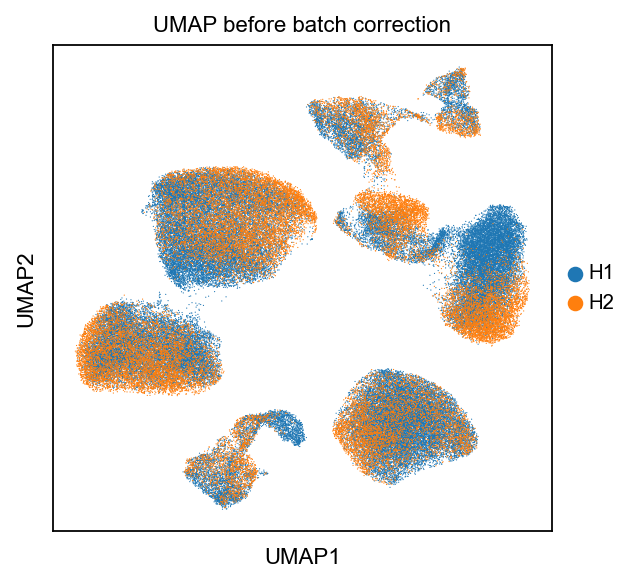

In [3]:
scyan.plot.umap(adata, color="subject", title="UMAP before batch correction")

### Provide batch information to Scyan

To correct the batch effect, you must have a column in `adata.obs` dedicated to the batch. Then, provide a `batch_key` to `scyan.Scyan`, i.e. the name of the column dedicated to the batch. You can also choose a `batch_ref`, i.e. one of all the batches you want to use, or let Scyan choose it for you (by default, the batch with the highest number of cells).

The batch knowledge is automatically added as one of the model `categorical_covariate_keys`. You can add more categorical or continuous covariates if needed (see [scyan.Scyan API](../../api/model)).

> If you use your own dataset, use `Scyan` default parameters first.

In [4]:
# You can modify 'alpha_batch_effect' to improve the batch effect correction
# NB: except 'batch_key', the other arguments are optional
model = scyan.Scyan(adata, marker_pop_matrix, prior_std=0.2, batch_key="subject", batch_ref="H1", alpha_batch_effect=50, batch_size=8192, hidden_size=32, temperature=0.5, modulo_temp=3, n_hidden_layers=7, n_layers=7, lr=0.0003, mmd_max_samples=2048)

# For batch effect correction, we advise to increase the default 'patience'
model.fit(patience=4)

INFO:scyan.model:Initialized Scyan model with N=104184 cells, P=14 populations and M=32 markers. Covariates: subject
INFO:scyan.model:Training scyan with the following hyperparameters:
"alpha_batch_effect": 50
"batch_key":          subject
"batch_ref":          H1
"batch_size":         8192
"hidden_size":        32
"lr":                 0.0003
"max_samples":        200000
"mmd_max_samples":    2048
"modulo_temp":        3
"n_hidden_layers":    7
"n_layers":           7
"prior_std":          0.2
"temperature":        0.5

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 117 K 
---------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.470     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:scyan.model:Successfully ended traning.


Scyan model with N=104184 cells, P=14 populations and M=32 markers. Covariates: subject

## Compare results to the ground truth

In [5]:
model.predict()  # Predictions are saved in adata.obs.scyan_pop by default

print(f"Model accuracy: {metrics.accuracy_score(adata.obs.cell_type, adata.obs.scyan_pop):.3f}")
print(f"Model f1-score: {metrics.f1_score(adata.obs.cell_type, adata.obs.scyan_pop, average='macro'):.3f}")
print(f"Model balanced acc: {metrics.balanced_accuracy_score(adata.obs.cell_type, adata.obs.scyan_pop):.3f}")

Model accuracy: 0.984
Model f1-score: 0.919
Model balanced acc: 0.920


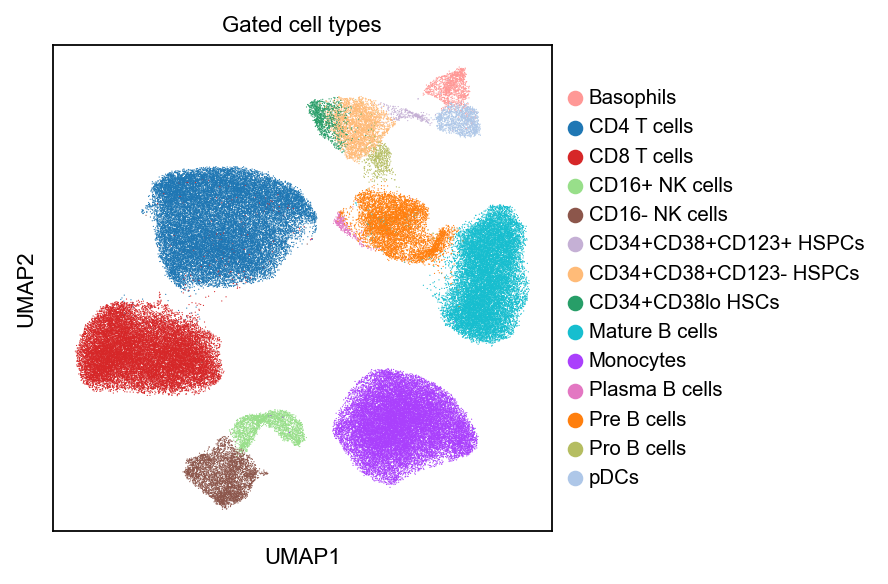

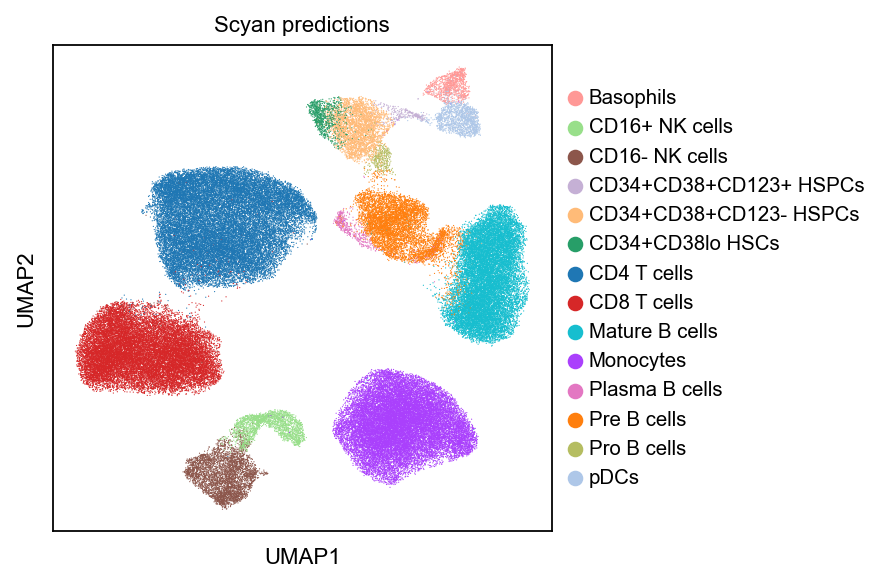

In [6]:
scyan.plot.umap(adata, color="cell_type", palette=adata.uns["palette"], title="Gated cell types")
scyan.plot.umap(adata, color="scyan_pop", palette=adata.uns["palette"], title="Scyan predictions")

## Run batch effect correction

In [7]:
# Get observed marker expressions (preprocess and standardised)
x = model.batch_effect_correction()

Use the previously trained UMAP reducer. Make sure you trained your UMAP on the same set of markers and on preprocess + standardized data, else it will make inconsistent results.

> You can also choose to fit a new UMAP reducer from scratch.

In [8]:
adata.obsm["X_umap"] = reducer.transform(x)

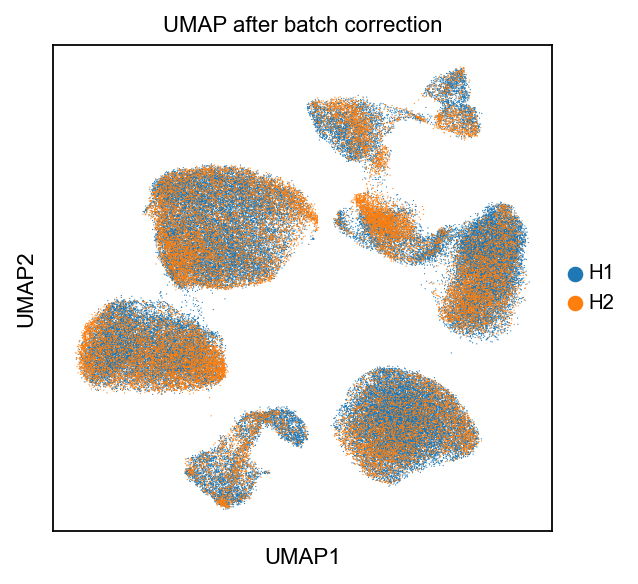

In [9]:
scyan.plot.umap(adata, color="subject", title="UMAP after batch correction")